## GRU 모델링

In [78]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

There are 496 observations in the training data
There are 77 observations in the test data


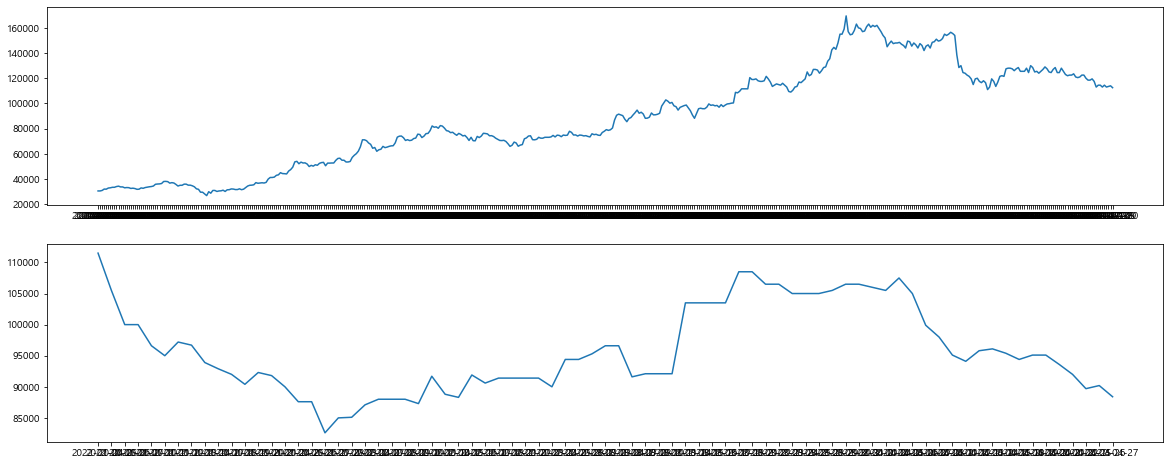

In [167]:
# 주가 데이터 불러오기
price_train = pd.read_csv('./data/주가_train_data.csv')
price_test = pd.read_csv('./data/주가_test_data.csv')

print("There are "+str(price_train.shape[0])+" observations in the training data")
print("There are "+str(price_test.shape[0])+" observations in the test data")

plt.figure(figsize=(20,8))
plt.subplot(211)
plt.plot(price_train['Date'],price_train['Close'])

plt.subplot(212)
plt.plot(price_test['Date'],price_test['Close'])

### train과 test를 합하여 진행

In [169]:
price = pd.concat([price_train,price_test], ignore_index = True)
price.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj.Close,Volume,일일종가차이
0,1,2020-01-02,30800.0,30900,30400.0,30500.0,30473.498047,1205235,-200
1,2,2020-01-03,30700.0,31000,30200.0,30500.0,30473.498047,1574240,0
2,3,2020-01-06,30100.0,31000,30000.0,30900.0,30873.152344,1968575,400
3,4,2020-01-07,31000.0,32000,30900.0,32000.0,31972.195313,4200930,1100
4,5,2020-01-08,31700.0,32400,31300.0,31900.0,31872.283203,4258095,-100


In [170]:
### 필요없는 열 삭제 및 날짜, 시가, 종가, 거래량만 불러옴
price = price.drop('Unnamed: 0', axis=1)
price = price[['Date','Open','Close','Volume']]
price

,Date,Open,Close,Volume
0,2020-01-02,30800.0,30500.0,1205235
1,2020-01-03,30700.0,30500.0,1574240
2,2020-01-06,30100.0,30900.0,1968575
3,2020-01-07,31000.0,32000.0,4200930
4,2020-01-08,31700.0,31900.0,4258095
...,...,...,...,...
568,2022-04-21,95100.0,93600.0,1809576
569,2022-04-22,92200.0,92000.0,1553904
570,2022-04-25,90400.0,89700.0,1511408
571,2022-04-26,89800.0,90200.0,1368258


In [131]:
price_train.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj.Close,Volume,일일종가차이
0,1,2020-01-02,30800.0,30900,30400.0,30500,30473.498047,1205235,-200
1,2,2020-01-03,30700.0,31000,30200.0,30500,30473.498047,1574240,0
2,3,2020-01-06,30100.0,31000,30000.0,30900,30873.152344,1968575,400
3,4,2020-01-07,31000.0,32000,30900.0,32000,31972.195313,4200930,1100
4,5,2020-01-08,31700.0,32400,31300.0,31900,31872.283203,4258095,-100


In [172]:
### 공휴일 및 주말의 경우 거래량이 없는 날도 있어 결측치 생김
price.loc[price['Volume']==0].head()

,Date,Open,Close,Volume
45,2020-03-09,35100.0,35100.0,0
315,2021-04-12,111600.0,111600.0,0
316,2021-04-13,111600.0,111600.0,0
317,2021-04-14,111600.0,111600.0,0
512,2022-01-26,87600.0,87600.0,0


In [174]:
# 결측치 NaN값으로 대체 후 확인
price['Volume'] = price['Volume'].replace(0, np.nan)
price.loc[price['Volume']==0]

price[45:].head(1)  # NaN 값으로 잘 바뀐 것을 볼 수 있음

,Date,Open,Close,Volume
45,2020-03-09,35100.0,35100.0,NaN


In [175]:
# NaN값 제거
price = price.dropna()
price.describe()

,Open,Close,Volume
count,555.000000,555.000000,5.550000e+02
mean,89387.747748,89397.837838,4.060512e+06
std,36585.141208,36468.394343,2.825433e+06
min,27600.000000,26800.000000,7.740640e+05
25%,66400.000000,66150.000000,2.117982e+06
50%,90400.000000,90600.000000,3.314525e+06
75%,118000.000000,118000.000000,4.928024e+06
max,172000.000000,169500.000000,1.889515e+07


In [132]:
# price_train = price_train.drop('Unnamed: 0', axis=1)
# price_test = price_test.drop('Unnamed: 0', axis=1)
price_train = price_train[['Date','Open','Close','Volume']]
price_train

,Date,Open,Close,Volume
0,2020-01-02,30800.0,30500,1205235
1,2020-01-03,30700.0,30500,1574240
2,2020-01-06,30100.0,30900,1968575
3,2020-01-07,31000.0,32000,4200930
4,2020-01-08,31700.0,31900,4258095
...,...,...,...,...
491,2021-12-24,113000.0,114500,1484508
492,2021-12-27,114000.0,113000,1116701
493,2021-12-28,113000.0,113500,2370856
494,2021-12-29,115500.0,114000,1791503


### Date 항목을 제외한 시작가, 종가, 거래량에 대해 정규화 작업 실시

In [143]:
scaler = MinMaxScaler()

In [144]:
# 정규화 시킬 columns
scale_cols = ['Open', 'Close', 'Volume']

In [145]:
scaled_df = scaler.fit_transform(price_train[scale_cols])

In [146]:
print(type(scaled_df),'\n') # numpy 로 리턴

<class 'numpy.ndarray'> 



In [147]:
scaled_df = pd.DataFrame(scaled_df, columns = scale_cols)
scaled_df

,Open,Close,Volume
0,0.022161,0.025929,0.012882
1,0.021468,0.025929,0.033473
2,0.017313,0.028732,0.055477
3,0.023546,0.036440,0.180045
4,0.028393,0.035739,0.183235
...,...,...,...
487,0.591413,0.614576,0.028466
488,0.598338,0.604064,0.007942
489,0.591413,0.607568,0.077925
490,0.608726,0.611072,0.045596


In [148]:
# 입력데이터는 시가, 종가, 거래량
# 정답데이터는 종가

feature_cols = ['Open','Close','Volume']
label_cols = ['Close']

label_df = pd.DataFrame(scaled_df, columns = label_cols)
feature_df = pd.DataFrame(scaled_df, columns = feature_cols)

print(feature_df)
print(label_df)

         Open     Close    Volume
0    0.022161  0.025929  0.012882
1    0.021468  0.025929  0.033473
2    0.017313  0.028732  0.055477
3    0.023546  0.036440  0.180045
4    0.028393  0.035739  0.183235
..        ...       ...       ...
487  0.591413  0.614576  0.028466
488  0.598338  0.604064  0.007942
489  0.591413  0.607568  0.077925
490  0.608726  0.611072  0.045596
491  0.598338  0.600561  0.013877

[492 rows x 3 columns]
        Close
0    0.025929
1    0.025929
2    0.028732
3    0.036440
4    0.035739
..        ...
487  0.614576
488  0.604064
489  0.607568
490  0.611072
491  0.600561

[492 rows x 1 columns]


In [149]:
# 모델에 학습을 시키려면 df를 numpy 파일로 변환해야 함
label_np = label_df.to_numpy()
feature_np = feature_df.to_numpy()

### 학습 데이터 생성

In [150]:
def make_sequence_dataset(feature, label, window_size):
    feature_list = []
    label_list = []
    
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
        
    return np.array(feature_list), np.array(label_list)

In [185]:
window_size = 40  # 40개의 시계열 데이터를 이용해서 다음의 종가를 예측
X, Y = make_sequence_dataset(feature_np, label_np, window_size)
print(X.shape, Y.shape)

(452, 40, 3) (452, 1)


In [186]:
# train, test 데이터 분리
split = -61 # 22년 

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(391, 40, 3) (391, 1)
(61, 40, 3) (61, 1)


### 모델 구축

In [187]:
model = Sequential()

In [188]:
model.add(GRU(256, # 256개의 노드를 가지는 GRU 레이어
             activation = 'tanh', # 활성함수는 tanh
             input_shape = x_train[0].shape))

In [189]:
model.add(Dense(1, activation = 'linear'))  # 출력층은 1개의 노드를 가짐

In [190]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 256)               200448    
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 200,705
Trainable params: 200,705
Non-trainable params: 0
_________________________________________________________________


### 모델 컴파일 및 학습

In [191]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse']) 
# 손실함수는 mse, 옵티마이저는 adam, 관찰대상 행렬은 오차의 절대값인 mae

early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)
# 손실이 5가 되면 멈추는 earlystopping 조건을 주고 모델 컴파일

model.fit(x_train, y_train, validation_data = (x_test, y_test), 
          epochs = 45, batch_size = 8, callbacks = [early_stop])
# early_stop 조건 아래에서 45번(epochs) 반복

Epoch 1/45
49/49 [==============================] - 3s 37ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 9.4057e-04 - val_mse: 9.4057e-04
Epoch 2/45
49/49 [==============================] - 2s 38ms/step - loss: 8.1509e-04 - mse: 8.1509e-04 - val_loss: 5.3377e-04 - val_mse: 5.3377e-04
Epoch 3/45
49/49 [==============================] - 1s 28ms/step - loss: 7.5677e-04 - mse: 7.5677e-04 - val_loss: 7.0809e-04 - val_mse: 7.0809e-04
Epoch 4/45
49/49 [==============================] - 2s 35ms/step - loss: 6.8324e-04 - mse: 6.8324e-04 - val_loss: 4.4295e-04 - val_mse: 4.4295e-04
Epoch 5/45
49/49 [==============================] - 1s 29ms/step - loss: 6.3218e-04 - mse: 6.3218e-04 - val_loss: 3.1668e-04 - val_mse: 3.1668e-04
Epoch 6/45
49/49 [==============================] - 1s 30ms/step - loss: 6.5410e-04 - mse: 6.5410e-04 - val_loss: 3.1253e-04 - val_mse: 3.1253e-04
Epoch 7/45
49/49 [==============================] - 2s 35ms/step - loss: 6.5667e-04 - mse: 6.5667e-04 - val_loss: 6.1760e-04 -

### 그림으로 확인

In [192]:
pred = model.predict(x_test)

In [90]:
# 그래프에서 한글 폰트가 깨질 경우 실행
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

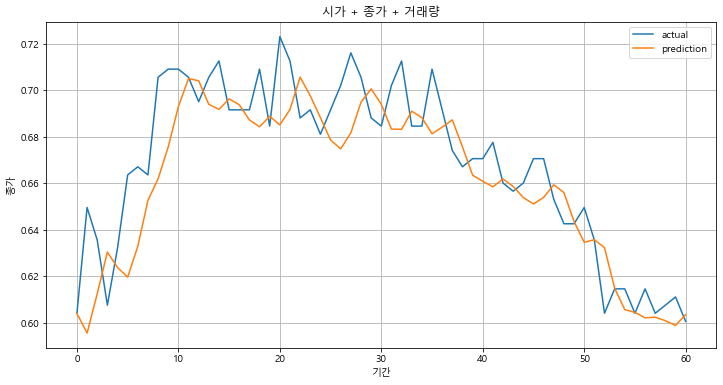

In [193]:
plt.figure(figsize=(12,6))
plt.title('시가 + 종가 + 거래량')
plt.ylabel('종가')
plt.xlabel('기간')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [200]:
# 평가지표 출력

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
MAE = mean_absolute_error(y_test, pred)
RMSE = np.sqrt(mean_squared_error(y_test, pred))
MSLE = mean_squared_log_error(y_test, pred)
RMSLE = np.sqrt(mean_squared_log_error(y_test,pred))
R2 = r2_score(y_test, pred)

pd.options.display.float_format = '{:.5f}'.format
Result = pd.DataFrame(data = [MAE, RMSE, RMSLE, R2],
                     index = ['MAE', 'RMSE', 'RMSLE', 'R2'],
                     columns = ['Results'])
Result

,Results
MAE,0.01439
RMSE,0.01894
RMSLE,0.01137
R2,0.72063
